# TASK 2: Experimentation and uplift testing

Extend your analysis from Task 1 to help you identify benchmark stores that allow you to test the impact of the trial store layouts on customer sales

#### Here is the background information on your task

You are part of Quantium’s retail analytics team and have been approached by your client, the Category Manager for Chips, has asked us to test the impact of the new trial layouts with a data driven recommendation to whether or not the trial layout should be rolled out to all their stores.

#### Here is your task

Julia has asked us to evaluate the performance of a store trial which was performed in stores 77, 86 and 88.

To get started use the QVI_data dataset below or your output from task 1 and consider the monthly sales experience of each store.

This can be broken down by:

- total sales revenue
- total number of customers
- average number of transactions per customer

Create a measure to compare different control storesto each of the trial stores to do this write a function to reduce having to re-do the analysis for each trial store. Consider using Pearson correlations or a metric such as a magnitude distance e.g. 1- (Observed distance – minimum distance)/(Maximum distance – minimum distance) as a measure.

Once you have selected your control stores, compare each trial and control pair during the trial period. You want to test if total sales are significantly different in the trial period and if so, check if the driver of change is more purchasing customers or more purchases per customers etc.

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xlrd

import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading the file
qvi_data= pd.read_csv("S:\Downloads\QVI_data.csv")
qvi_data

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream
...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget


In [3]:
# Schema Summary
qvi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [4]:
#Checking null values
qvi_data.isnull().sum()

LYLTY_CARD_NBR      0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

We will start by assigning a control store, which were stores 77,86 and 88, because we want to find stores that have similar attributes to that of the trial stores prior to the entire duration of recorded sales.

#### Firstly, we need to aggregate some statistics about the stores for each recorded month over the entre duration of sales:-

In [5]:
qvi_data['YEAR_MONTH'] = pd.to_datetime(qvi_data['DATE']).dt.to_period('M') 
#Can only use .dt accessor with datetimelike values
qvi_data

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEAR_MONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream,2018-12
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium,2018-10
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget,2018-10
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget,2018-10


In [6]:
#1. Total Sales Revenue

total_sales= qvi_data.groupby(['STORE_NBR','YEAR_MONTH'])['TOT_SALES'].sum()
total_sales.reset_index()

,STORE_NBR,YEAR_MONTH,TOT_SALES
0,1,2018-07,206.9
1,1,2018-08,176.1
2,1,2018-09,278.8
3,1,2018-10,188.1
4,1,2018-11,192.6
...,...,...,...
3164,272,2019-02,395.5
3165,272,2019-03,442.3
3166,272,2019-04,445.1
3167,272,2019-05,314.6


In [7]:
#2. Total Number of Customers

total_customers= qvi_data.groupby(['STORE_NBR','YEAR_MONTH'])['LYLTY_CARD_NBR'].nunique()
total_customers.reset_index()

,STORE_NBR,YEAR_MONTH,LYLTY_CARD_NBR
0,1,2018-07,49
1,1,2018-08,42
2,1,2018-09,59
3,1,2018-10,44
4,1,2018-11,46
...,...,...,...
3164,272,2019-02,45
3165,272,2019-03,50
3166,272,2019-04,54
3167,272,2019-05,34


In [8]:
#3. Average Number of Transactions per Customer

transaction_per_customer= qvi_data.groupby(['STORE_NBR','YEAR_MONTH'])['TXN_ID'].nunique()/qvi_data.groupby(['STORE_NBR','YEAR_MONTH'])['LYLTY_CARD_NBR'].nunique()
transaction_per_customer.reset_index()

,STORE_NBR,YEAR_MONTH,0
0,1,2018-07,1.061224
1,1,2018-08,1.023810
2,1,2018-09,1.050847
3,1,2018-10,1.022727
4,1,2018-11,1.021739
...,...,...,...
3164,272,2019-02,1.066667
3165,272,2019-03,1.060000
3166,272,2019-04,1.018519
3167,272,2019-05,1.176471


In [9]:
df_list= [total_sales,total_customers,transaction_per_customer]
df= pd.concat(df_list,axis=1)
df.columns=['TOT_SALES','TOT_CUST','TXN_PER_CUST']
df

TOT_SALES  TOT_CUST  TXN_PER_CUST
STORE_NBR YEAR_MONTH                                   
1         2018-07         206.9        49      1.061224
          2018-08         176.1        42      1.023810
          2018-09         278.8        59      1.050847
          2018-10         188.1        44      1.022727
          2018-11         192.6        46      1.021739
...                         ...       ...           ...
272       2019-02         395.5        45      1.066667
          2019-03         442.3        50      1.060000
          2019-04         445.1        54      1.018519
          2019-05         314.6        34      1.176471
          2019-06         312.1        34      1.088235

[3169 rows x 3 columns]

In [10]:
df.isnull().sum()

TOT_SALES       0
TOT_CUST        0
TXN_PER_CUST    0
dtype: int64

- Since the dataset contains transaction details of many stores, there may be some stores that did not record sales for the entire recorded_stores

In [11]:
recorded_stores= pd.pivot_table(qvi_data, index='STORE_NBR',columns='YEAR_MONTH',values='TXN_ID',aggfunc='count')
recorded_stores

YEAR_MONTH,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06
STORE_NBR,,,,,,,,,,,,
1,52.0,43.0,62.0,45.0,47.0,47.0,36.0,55.0,49.0,43.0,51.0,43.0
2,41.0,43.0,37.0,43.0,40.0,38.0,45.0,32.0,46.0,49.0,50.0,42.0
3,138.0,134.0,119.0,119.0,118.0,129.0,121.0,139.0,130.0,110.0,123.0,122.0
4,160.0,151.0,138.0,155.0,139.0,133.0,168.0,102.0,135.0,137.0,126.0,134.0
5,120.0,112.0,125.0,107.0,111.0,125.0,118.0,106.0,97.0,109.0,104.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...
268,52.0,54.0,34.0,48.0,51.0,43.0,38.0,37.0,47.0,50.0,52.0,40.0
269,139.0,132.0,124.0,148.0,136.0,133.0,144.0,133.0,122.0,139.0,130.0,127.0
270,139.0,154.0,126.0,119.0,133.0,149.0,155.0,125.0,143.0,132.0,128.0,127.0


In [12]:
recorded_stores.isnull().sum()

YEAR_MONTH
2018-07    6
2018-08    9
2018-09    8
2018-10    7
2018-11    8
2018-12    9
2019-01    9
2019-02    8
2019-03    7
2019-04    7
2019-05    9
2019-06    8
Freq: M, dtype: int64

We can see, there are null values for a few months, which means that some of these are unrecorded for certain stores, so we need to find them and remove these stores from the dataset, As they can't be control stores anyway.

In [13]:
unrecorded_stores=[]
for i in recorded_stores.index:
    if recorded_stores.loc[i].isnull().any():
        #.any: any element comes in the row which is null, condition satisfied there only , no need to check futher
        unrecorded_stores.append(i)
unrecorded_stores
#loc[i]: To access rows       i: row number

[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]

In [14]:
df= df.drop(unrecorded_stores,axis=0)

In [15]:
df

TOT_SALES  TOT_CUST  TXN_PER_CUST
STORE_NBR YEAR_MONTH                                   
1         2018-07         206.9        49      1.061224
          2018-08         176.1        42      1.023810
          2018-09         278.8        59      1.050847
          2018-10         188.1        44      1.022727
          2018-11         192.6        46      1.021739
...                         ...       ...           ...
272       2019-02         395.5        45      1.066667
          2019-03         442.3        50      1.060000
          2019-04         445.1        54      1.018519
          2019-05         314.6        34      1.176471
          2019-06         312.1        34      1.088235

[3120 rows x 3 columns]

We can filter the dataset to the pre-trial duration. So that we can find the perfect Control Stores matching to our Trial Stores

In [16]:
pre_trial_data= df[df.index.get_level_values('YEAR_MONTH') <'2019-02'].reset_index()
#pre_trial_data= df[df['YEAR_MONTH'] <'2019-02']--Wrong  coz 'YEAR_MONTH' is not a column of df its his index
pre_trial_data

,STORE_NBR,YEAR_MONTH,TOT_SALES,TOT_CUST,TXN_PER_CUST
0,1,2018-07,206.9,49,1.061224
1,1,2018-08,176.1,42,1.023810
2,1,2018-09,278.8,59,1.050847
3,1,2018-10,188.1,44,1.022727
4,1,2018-11,192.6,46,1.021739
...,...,...,...,...,...
1815,272,2018-09,304.7,32,1.125000
1816,272,2018-10,430.6,44,1.136364
1817,272,2018-11,376.2,41,1.097561
1818,272,2018-12,403.9,47,1.000000


- From the pre-trial dataset, we can now filter the Control Stores, which are the ones that do not include STORE_NBR 77,86 and 88

In [17]:
control_stores=pre_trial_data[(pre_trial_data.STORE_NBR!=77 ) & (pre_trial_data.STORE_NBR!=86) & (pre_trial_data.STORE_NBR!=88)] [["TOT_SALES", "TOT_CUST", "TXN_PER_CUST"]].groupby(pre_trial_data.STORE_NBR).sum()
control_stores

,TOT_SALES,TOT_CUST,TXN_PER_CUST
STORE_NBR,,,
1,1386.90,317,7.327967
2,1128.50,272,7.359700
3,7526.15,744,8.209829
4,9127.00,849,8.535253
5,5739.70,651,8.791906
...,...,...,...
268,1549.05,304,7.373037
269,6664.50,746,8.921035
270,6697.95,734,9.147187


In [18]:
trial_stores= pre_trial_data[(pre_trial_data.STORE_NBR==77) | (pre_trial_data.STORE_NBR==86) | (pre_trial_data.STORE_NBR==88)] [['TOT_SALES','TOT_CUST','TXN_PER_CUST']].groupby(pre_trial_data.STORE_NBR).sum()
trial_stores

,TOT_SALES,TOT_CUST,TXN_PER_CUST
STORE_NBR,,,
77,1699.00,299,7.405289
86,6119.85,697,8.798544
88,9383.60,880,8.523817


#### With both the control stores and the trial stores filtered, we can find the Pearson correlation coefficient of the attributes between the two to find the control stores for each of the trial stores

In [19]:
correlation=control_stores.loc[control_stores.corrwith(trial_stores.loc[77], method="pearson", axis=1).nlargest(3).index]
# Getting the difference between the trial store and the top three stores with the highest correlation with the trial store.
difference=(trial_stores.loc[77]-correlation)
#difference of our trial store with all its top 3 control stores : by it we can examine which is more close to it
difference


,TOT_SALES,TOT_CUST,TXN_PER_CUST
STORE_NBR,,,
161,1459.0,252.0,0.405289
135,1486.9,256.0,0.012432
233,39.2,1.0,0.115969


For STORE_NBR 77 we can see that STRORE_NBR 46 is most suitable Control Store.

In [20]:
correlation=control_stores.loc[control_stores.corrwith(trial_stores.loc[86], axis=1).nlargest(3).index]  
difference=(trial_stores.loc[86]-correlation).sort_values(by="TOT_SALES", ascending=False)
difference 

,TOT_SALES,TOT_CUST,TXN_PER_CUST
STORE_NBR,,,
215,3411.85,386.0,1.486773
225,29.25,3.0,0.023669
57,-27.55,-2.0,0.031815


For STORE_NBR 86 we can see that STRORE_NBR 57 is most suitable Control Store.

In [21]:
correlation=control_stores.loc[control_stores.corrwith(trial_stores.loc[88], axis=1).nlargest(3).index]  
difference=(trial_stores.loc[86]-correlation).sort_values(by="TOT_SALES", ascending=False)
difference 

,TOT_SALES,TOT_CUST,TXN_PER_CUST
STORE_NBR,,,
75,-1843.65,-54.0,0.353712
72,-2398.65,-104.0,0.360597
203,-2823.85,-145.0,0.409866


For STORE_NBR 88 we can see that STRORE_NBR 203 is suitable Control Store over STORE_NBR 72

In [35]:
#Trial Stores

trial_store_one=pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([77])].reset_index()
trial_store_two=pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([86])].reset_index()
trial_store_three=pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([88])].reset_index()

In [34]:
#Control Stores

control_store_one=pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([233])].reset_index()
control_store_two=pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([57])].reset_index()
control_store_three=pre_trial_data.loc[pre_trial_data.STORE_NBR.isin([203])].reset_index()


In [40]:
stores=pd.concat([trial_store_one, control_store_one, trial_store_two, control_store_two, trial_store_three, control_store_three], axis=0)   
stores

,index,STORE_NBR,YEAR_MONTH,TOT_SALES,TOT_CUST,TXN_PER_CUST
0,504,77,2018-07,296.80,51,1.078431
1,505,77,2018-08,255.50,47,1.021277
2,506,77,2018-09,225.20,42,1.047619
3,507,77,2018-10,204.50,37,1.027027
4,508,77,2018-11,245.30,41,1.073171
5,509,77,2018-12,267.30,46,1.043478
6,510,77,2019-01,204.40,35,1.114286
0,1547,233,2018-07,290.70,51,1.058824
1,1548,233,2018-08,285.90,48,1.041667
2,1549,233,2018-09,228.60,42,1.071429


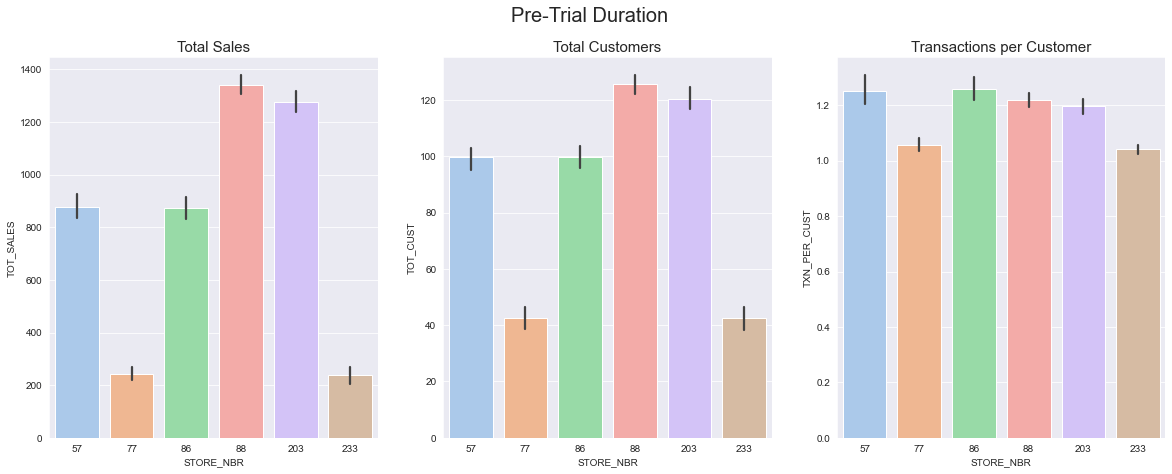

In [41]:
sns.set_style("darkgrid")
figure, axis=plt.subplots(1, 3, figsize=(20, 7))

sns.barplot(x="STORE_NBR", y="TOT_SALES", data=stores, ax=axis[0], palette="pastel")
axis[0].set_title("Total Sales",size=15)

sns.barplot(x="STORE_NBR", y="TOT_CUST", data=stores, ax=axis[1], palette="pastel")
axis[1].set_title("Total Customers",size=15)

sns.barplot(x="STORE_NBR", y="TXN_PER_CUST", data=stores, ax=axis[2], palette="pastel")
axis[2].set_title("Transactions per Customer",size=15)

figure.suptitle("Pre-Trial Duration",size=20)
plt.show()

While the other trial stores performed the same as their corresponding control stores, we can see, however, that STORE_NBR 88 out-performed its control store STORE_NBR 203in all attributes.  

### Likewise, we can also compare different control stores to each of the trial stores during the trial duration, as well, to find if the total sales are significantly different in the trial duration.

In [42]:
trial_data = df[(df.index.get_level_values('YEAR_MONTH') >= '2019-02') 
                & (df.index.get_level_values('YEAR_MONTH') <= '2019-04')].reset_index()
trial_data

,STORE_NBR,YEAR_MONTH,TOT_SALES,TOT_CUST,TXN_PER_CUST
0,1,2019-02,225.4,52,1.057692
1,1,2019-03,192.9,45,1.088889
2,1,2019-04,192.9,42,1.023810
3,2,2019-02,139.4,29,1.103448
4,2,2019-03,192.1,43,1.069767
...,...,...,...,...,...
775,271,2019-03,735.8,79,1.278481
776,271,2019-04,774.6,87,1.252874
777,272,2019-02,395.5,45,1.066667
778,272,2019-03,442.3,50,1.060000


In [43]:
trial_stores_one=trial_data.loc[trial_data.STORE_NBR.isin([77])]
trial_stores_two=trial_data.loc[trial_data.STORE_NBR.isin([86])]
trial_stores_three=trial_data.loc[trial_data.STORE_NBR.isin([88])]

In [44]:
control_stores_one=trial_data.loc[trial_data.STORE_NBR.isin([233])]
control_stores_two=trial_data.loc[trial_data.STORE_NBR.isin([57])]
control_stores_three=trial_data.loc[trial_data.STORE_NBR.isin([203])]

In [45]:
stores=pd.concat([trial_stores_one, control_stores_one, trial_stores_two, control_stores_two, trial_stores_three, control_stores_three], axis=0)
stores

,STORE_NBR,YEAR_MONTH,TOT_SALES,TOT_CUST,TXN_PER_CUST
216,77,2019-02,235.0,45,1.000000
217,77,2019-03,278.5,50,1.100000
218,77,2019-04,263.5,47,1.021277
663,233,2019-02,244.0,45,1.044444
664,233,2019-03,199.1,40,1.025000
665,233,2019-04,158.6,30,1.066667
240,86,2019-02,913.2,107,1.289720
241,86,2019-03,1026.8,115,1.217391
242,86,2019-04,848.2,105,1.200000
159,57,2019-02,919.8,108,1.194444


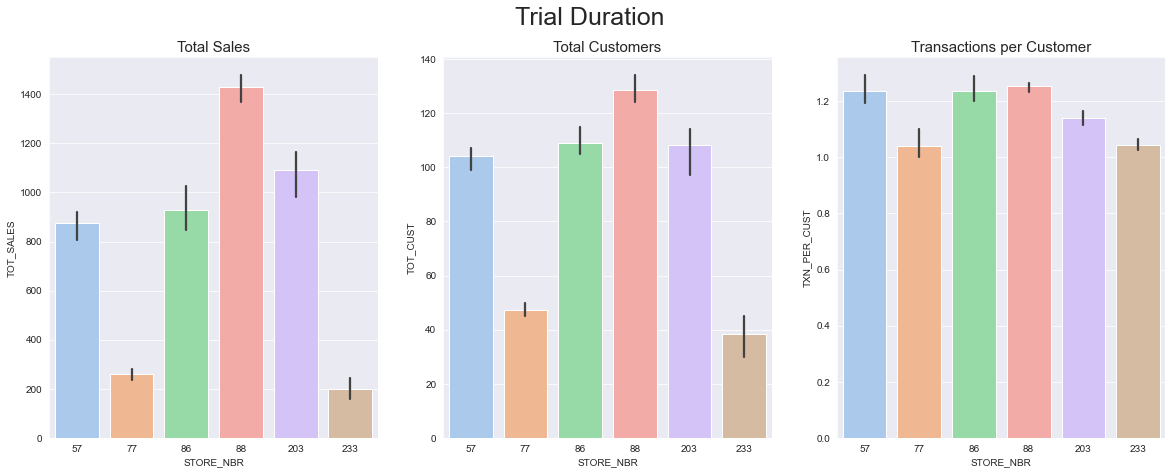

In [46]:
sns.set_style("darkgrid")
figure, axis=plt.subplots(1, 3, figsize=(20, 7))

sns.barplot(x="STORE_NBR", y="TOT_SALES", data=stores, ax=axis[0], palette="pastel")
axis[0].set_title("Total Sales",size=15)

sns.barplot(x="STORE_NBR", y="TOT_CUST", data=stores, ax=axis[1], palette="pastel")
axis[1].set_title("Total Customers",size=15)

sns.barplot(x="STORE_NBR", y="TXN_PER_CUST", data=stores, ax=axis[2], palette="pastel")
axis[2].set_title("Transactions per Customer",size=15)

figure.suptitle("Trial Duration",size=25)
plt.show()

By analysing and comparing this graph, each of our Trial Stores out perform their Control Stores in Total Number of customers gather result in out-performance in Total Sales. Hence the Product layout effectively working.

# Conclusion:

### Pre-Trial Duration

While most Trial Stores performed similarly to their Control Stores, STORE_NBR 88 significantly outperformed its counterpart, STORE_NBR 203, across all metrics 

### Trial Duration

Our Trial Stores demonstrated a significant advantage over Control Stores, attracting more customers and consequently generating higher total sales.


### Suggestion

The successful performance of Trial Stores during the trial period, characterized by increased customer footfall and sales, strongly supports the implementation of the new product layout across all stores. This strategic move has the potential to significantly enhance customer experience and drive overall sales growth.